# 1. Train Test Split(80:20)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, precision_score, recall_score, confusion_matrix, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("D:/AI/Case_Studies/Personal_Case_Study_1/Data/Processed/final_train_data.csv")
X =  df.drop(['Provider', 'PotentialFraud'], axis=1)
Y = df['PotentialFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
print("Shape of train data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)

Shape of train data:  (3787, 33)
Shape of test data:  (1623, 33)


In [3]:
from collections import Counter
train_y = dict(Counter(y_train))
test_y = dict(Counter(y_test))

print("Percentage of (PotentialFraud==1) in train data:{}% ".format(train_y[1]/(train_y[1]+train_y[0])*100))
print("Percentage of (PotentialFraud==1) in test data:{}% ".format(test_y[1]/(test_y[1]+test_y[0])*100))

Percentage of (PotentialFraud==1) in train data:9.347768682334301% 
Percentage of (PotentialFraud==1) in test data:9.365372766481823% 


# 2. Data Balancing

In [4]:
sm = SMOTE(sampling_strategy=0.25, random_state=42)
X_bal, y_bal = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_bal))

Resampled dataset shape Counter({0: 3433, 1: 858})


# 3. Evaluation Functions

In [5]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# 4. Modelling

## 4.1 Standardizing Data

In [6]:
# Standardizing original data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardizing balanced data
scaler2 = StandardScaler()
X_bal_train = scaler2.fit_transform(X_bal)
X_bal_test = scaler2.transform(X_test)

## 4.2  Logistic Regression without SMOTE(Original Data)

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
c_range = np.logspace(-4, 4, 20)

clf = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000),
                   param_grid = {'C':c_range},
                   scoring='f1',
                   n_jobs=-1)

clf.fit(X_train_scaled, y_train)
print("Best F1 score obtained was: ", clf.best_score_)
best_log_model = clf.best_estimator_
print(best_log_model)

Best F1 score obtained was:  0.5637461421244743
LogisticRegression(C=0.23357214690901212, class_weight='balanced',
                   max_iter=1000)


In [9]:
# Train and test predictions
y_train_pred = best_log_model.predict(X_train_scaled)
y_test_pred = best_log_model.predict(X_test_scaled)
y_train_prob = best_log_model.predict_proba(X_train_scaled)
y_test_prob = best_log_model.predict_proba(X_test_scaled)

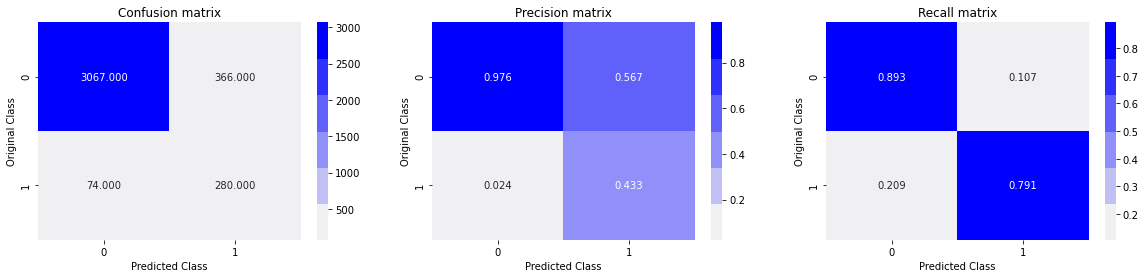

F1 score for train data:  0.5600000000000002
Recall for train data:  0.7909604519774012
Precision for train data:  0.43343653250773995


In [10]:
# Train Data Evaluation
plot_confusion_matrix(y_train, y_train_pred)
print("F1 score for train data: ", f1_score(y_train, y_train_pred))
print("Recall for train data: ", recall_score(y_train, y_train_pred))
print("Precision for train data: ", precision_score(y_train, y_train_pred))

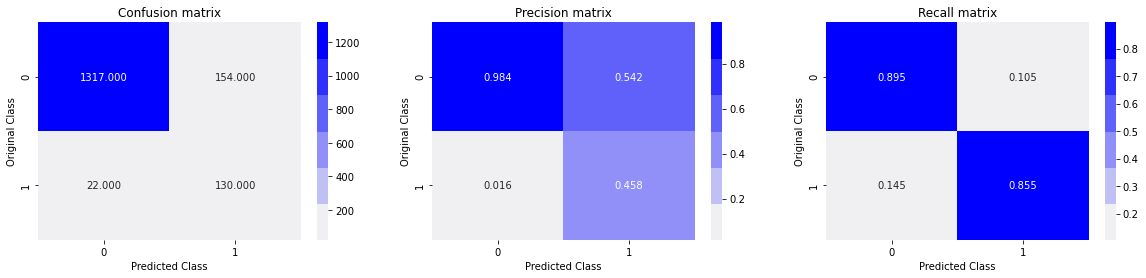

F1 score for test data:  0.5963302752293578
Recall for test data:  0.8552631578947368
Precision for test data:  0.45774647887323944


In [11]:
# Test Data Evaluation
plot_confusion_matrix(y_test, y_test_pred)
print("F1 score for test data: ", f1_score(y_test, y_test_pred))
print("Recall for test data: ", recall_score(y_test, y_test_pred))
print("Precision for test data: ", precision_score(y_test, y_test_pred))

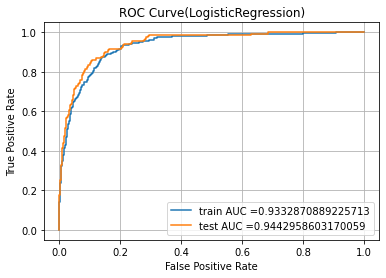

In [12]:
# AUC Score
train_fpr_tfidf, train_tpr_tfidf, tr_thresholds_tfidf = roc_curve(y_train, y_train_prob[:, 1])
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_prob[:, 1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(LogisticRegression)")
plt.grid()
plt.show()

## Observations:
<ul>
    <li> Logisitic Regression model gives a better recall score on test dataset i.e no. of False Negative is very less but there is an increase in False Positives which results in less precision. </li>
    <li> The no. of false negatives is very low on test set, which meets out business requirement. </li>
    <li> Test AUC score is higher than train auc score, the model is able to generalize well.
</ul>

## 4.3 SVM

In [13]:
from sklearn.svm import SVC

In [14]:
c_range = np.logspace(-3, 2, 5)
gamma = np.logspace(-2, 3, 15)

clf = GridSearchCV(SVC(class_weight='balanced', probability=True),
                   param_grid = {'C':c_range, 'gamma':gamma},
                   scoring='f1', verbose=1,
                   n_jobs=-1, cv=3)

clf.fit(X_bal_train, y_bal)
print("Best F1 score obtained was: ", clf.best_score_)
svm_model = clf.best_estimator_
print(svm_model)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best F1 score obtained was:  0.8325627650812594
SVC(C=100.0, class_weight='balanced', gamma=0.2682695795279726,
    probability=True)


In [15]:
# Train and test predictions
y_train_pred = svm_model.predict(X_bal_train)
y_test_pred = svm_model.predict(X_bal_test)
y_train_prob = svm_model.predict_proba(X_bal_train)
y_test_prob = svm_model.predict_proba(X_bal_test)

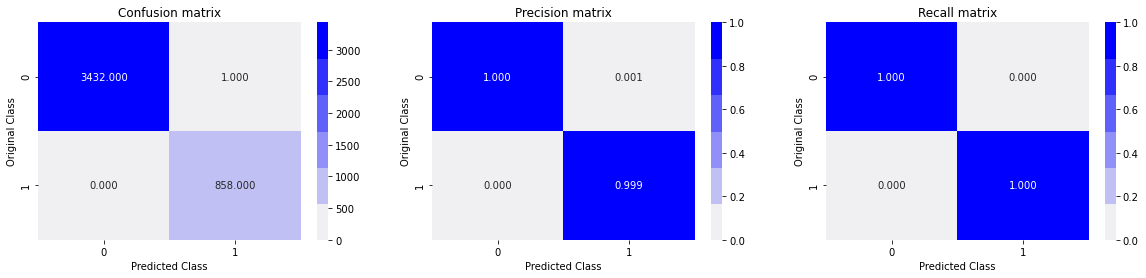

F1 score for train data:  0.9994175888177053
Recall for train data:  1.0
Precision for train data:  0.9988358556461001


In [16]:
# Train Data Evaluation
plot_confusion_matrix(y_bal, y_train_pred)
print("F1 score for train data: ", f1_score(y_bal, y_train_pred))
print("Recall for train data: ", recall_score(y_bal, y_train_pred))
print("Precision for train data: ", precision_score(y_bal, y_train_pred))

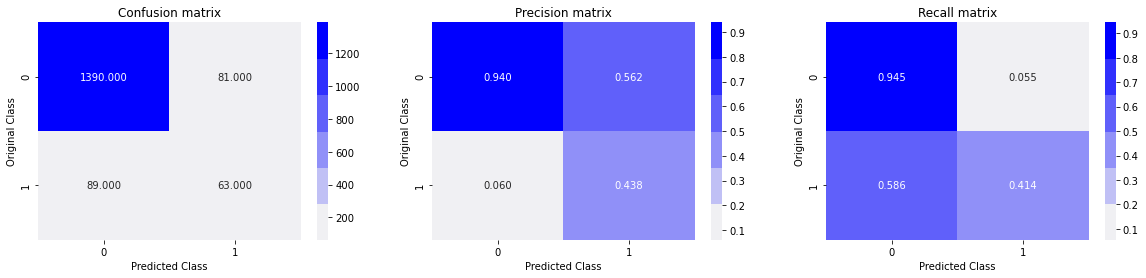

F1 score for test data:  0.42567567567567566
Recall for test data:  0.4144736842105263
Precision for test data:  0.4375


In [17]:
# Test Data Evaluation
plot_confusion_matrix(y_test, y_test_pred)
print("F1 score for test data: ", f1_score(y_test, y_test_pred))
print("Recall for test data: ", recall_score(y_test, y_test_pred))
print("Precision for test data: ", precision_score(y_test, y_test_pred))

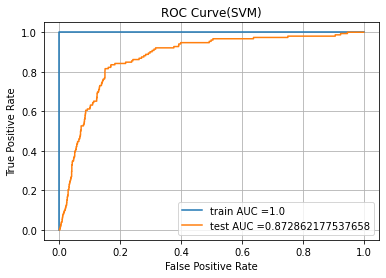

In [18]:
# AUC Score
train_fpr_tfidf, train_tpr_tfidf, tr_thresholds_tfidf = roc_curve(y_bal, y_train_prob[:, 1])
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_prob[:, 1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(SVM)")
plt.grid()
plt.show()

## Observations:
<ul>
    <li> SVM is overfitting on the data, and the performance of Logistic Regression is much better. </li>
</ul>

## 4.4 Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
clf = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'),
                   param_grid = {'max_depth': [2, 5, 15, 25, 50, 75, 100],
                                 'min_samples_split': [2, 3, 5, 7, 10],
                                 'min_samples_leaf': [1, 3, 5],
                                 'max_features': ['auto', 'sqrt', 'log2', 33]},
                   scoring='f1', verbose=1,
                   n_jobs=-1, cv=3)

clf.fit(X_bal, y_bal)
print("Best F1 score obtained was: ", clf.best_score_)
tree_model = clf.best_estimator_
print(tree_model)

Fitting 3 folds for each of 420 candidates, totalling 1260 fits
Best F1 score obtained was:  0.7533637009379192
DecisionTreeClassifier(class_weight='balanced', max_depth=75,
                       max_features='auto', min_samples_split=5)


In [21]:
clf.best_params_

{'max_depth': 75,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [22]:
# Train and test predictions
y_train_pred = svm_model.predict(X_bal_train)
y_test_pred = svm_model.predict(X_bal_test)
y_train_prob = svm_model.predict_proba(X_bal_train)
y_test_prob = svm_model.predict_proba(X_bal_test)

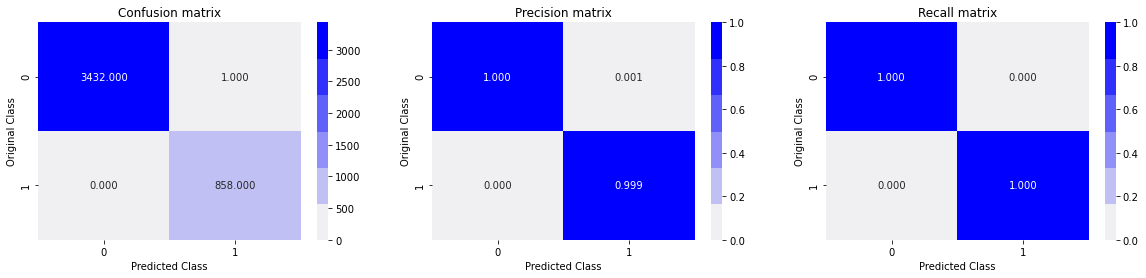

F1 score for train data:  0.9994175888177053
Recall for train data:  1.0
Precision for train data:  0.9988358556461001


In [23]:
# Train Data Evaluation
plot_confusion_matrix(y_bal, y_train_pred)
print("F1 score for train data: ", f1_score(y_bal, y_train_pred))
print("Recall for train data: ", recall_score(y_bal, y_train_pred))
print("Precision for train data: ", precision_score(y_bal, y_train_pred))

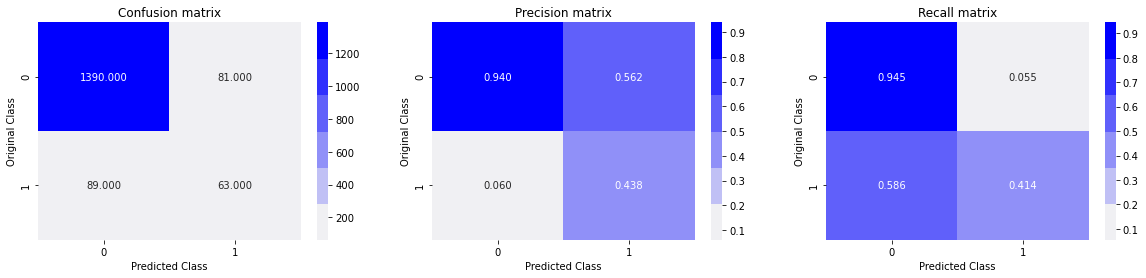

F1 score for test data:  0.42567567567567566
Recall for test data:  0.4144736842105263
Precision for test data:  0.4375


In [24]:
# Test Data Evaluation
plot_confusion_matrix(y_test, y_test_pred)
print("F1 score for test data: ", f1_score(y_test, y_test_pred))
print("Recall for test data: ", recall_score(y_test, y_test_pred))
print("Precision for test data: ", precision_score(y_test, y_test_pred))

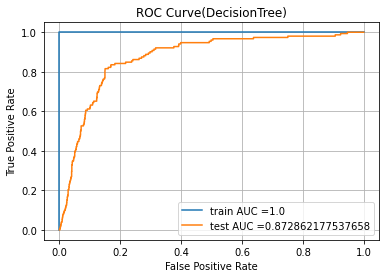

In [25]:
# AUC Score
train_fpr_tfidf, train_tpr_tfidf, tr_thresholds_tfidf = roc_curve(y_bal, y_train_prob[:, 1])
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_prob[:, 1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(DecisionTree)")
plt.grid()
plt.show()

## Observation:
<ul>
    <li> Like SVM, Decision Tree Classifier has also overfit, and failed to outperform Logistic Regression Model. </li>
</ul>

## 4.5 lightgbm

In [26]:
import lightgbm
clf = GridSearchCV(lightgbm.LGBMClassifier(class_weight='balanced'),
                   param_grid = {'learning_rate': [0.001, 0.002, 0.005, 0.1, 0.3, 0.5, 0.7],
                                 'n_estimators': [50, 100, 200, 300, 500]},
                   scoring='f1', verbose=1,
                   n_jobs=-1, cv=3)

clf.fit(X_bal_train, y_bal)
print("Best F1 score obtained was: ", clf.best_score_)
gbdt_model = clf.best_estimator_
print(gbdt_model)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best F1 score obtained was:  0.851523306118632
LGBMClassifier(class_weight='balanced', n_estimators=500)


In [27]:
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [28]:
# Train and test predictions
y_train_pred = gbdt_model.predict(X_bal_train)
y_test_pred = gbdt_model.predict(X_bal_test)
y_train_prob = gbdt_model.predict_proba(X_bal_train)
y_test_prob = gbdt_model.predict_proba(X_bal_test)

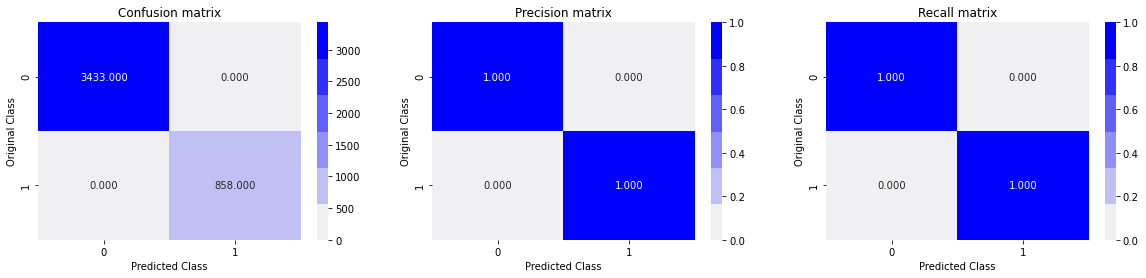

F1 score for train data:  1.0
Recall for train data:  1.0
Precision for train data:  1.0


In [29]:
# Train Data Evaluation
plot_confusion_matrix(y_bal, y_train_pred)
print("F1 score for train data: ", f1_score(y_bal, y_train_pred))
print("Recall for train data: ", recall_score(y_bal, y_train_pred))
print("Precision for train data: ", precision_score(y_bal, y_train_pred))

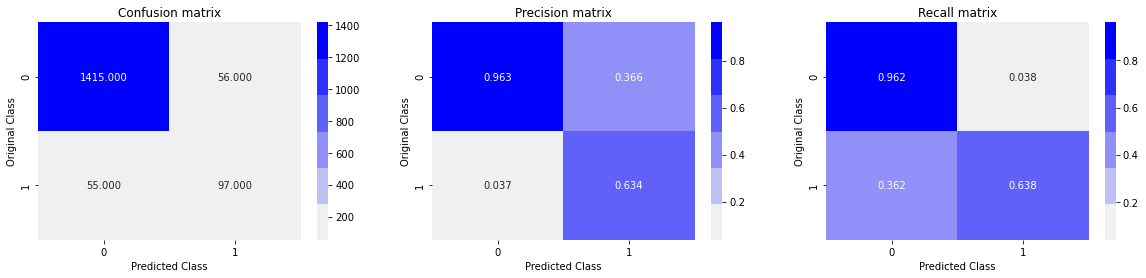

F1 score for test data:  0.6360655737704919
Recall for test data:  0.6381578947368421
Precision for test data:  0.6339869281045751


In [30]:
# Test Data Evaluation
plot_confusion_matrix(y_test, y_test_pred)
print("F1 score for test data: ", f1_score(y_test, y_test_pred))
print("Recall for test data: ", recall_score(y_test, y_test_pred))
print("Precision for test data: ", precision_score(y_test, y_test_pred))

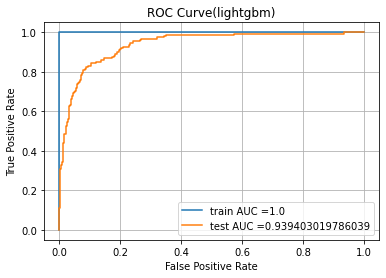

In [31]:
# AUC Score
train_fpr_tfidf, train_tpr_tfidf, tr_thresholds_tfidf = roc_curve(y_bal, y_train_prob[:, 1])
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_prob[:, 1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(lightgbm)")
plt.grid()
plt.show()

## Observations:
<ul> 
<li> lightgbm performs better than DecisionTree and SVM, and gives a better precision than Logisitic Regression on test set. </li>
<li> The no. of false positives is lesser than Logistic Regression model, but Logistic Regression model has lesser false negatives. </li>
<li> The F1 score of lightgbm model is better than Logistic Regression on test set, but lightgbm has overfit the data. </li>

## 4.6 RandomForest Model

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                   param_grid = {'n_estimators': [50, 100, 200, 300, 500, 1000],
                                 'max_depth': [5, 10, 50, None],
                                 'max_features': ['auto', 'sqrt', 'log2']},
                   scoring='f1', verbose=1,
                   n_jobs=-1, cv=3)

clf.fit(X_bal_train, y_bal)
print("Best F1 score obtained was: ", clf.best_score_)
forest_model = clf.best_estimator_
print(forest_model)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best F1 score obtained was:  0.8228098256683297
RandomForestClassifier(class_weight='balanced')


In [34]:
# Train and test predictions
y_train_pred = forest_model.predict(X_bal_train)
y_test_pred = forest_model.predict(X_bal_test)
y_train_prob = forest_model.predict_proba(X_bal_train)
y_test_prob = forest_model.predict_proba(X_bal_test)

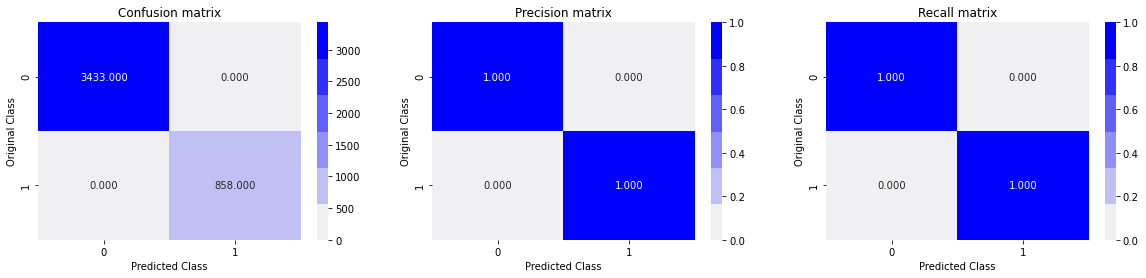

F1 score for train data:  1.0
Recall for train data:  1.0
Precision for train data:  1.0


In [35]:
# Train Data Evaluation
plot_confusion_matrix(y_bal, y_train_pred)
print("F1 score for train data: ", f1_score(y_bal, y_train_pred))
print("Recall for train data: ", recall_score(y_bal, y_train_pred))
print("Precision for train data: ", precision_score(y_bal, y_train_pred))

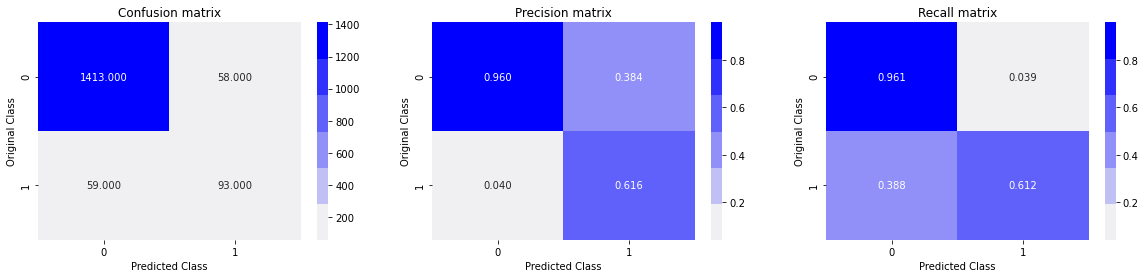

F1 score for test data:  0.613861386138614
Recall for test data:  0.6118421052631579
Precision for test data:  0.6158940397350994


In [36]:
# Test Data Evaluation
plot_confusion_matrix(y_test, y_test_pred)
print("F1 score for test data: ", f1_score(y_test, y_test_pred))
print("Recall for test data: ", recall_score(y_test, y_test_pred))
print("Precision for test data: ", precision_score(y_test, y_test_pred))

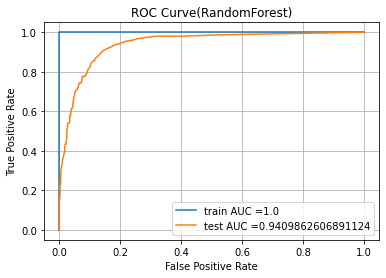

In [37]:
# AUC Score
train_fpr_tfidf, train_tpr_tfidf, tr_thresholds_tfidf = roc_curve(y_bal, y_train_prob[:, 1])
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_prob[:, 1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(RandomForest)")
plt.grid()
plt.show()

## Observations:
<ul>
    <li> RandomForest model overfits on the data, it's performance on test set is better than SVM and Decision Tree but worse than lightgbm. </li>
    <li> The best model is Logistic Regression with the highest recall score, and it manages to generalize well without overfitting on the data. </li>
</ul>

# 5. Feature Importance with Logistic Regression model

C:\Users\shahu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


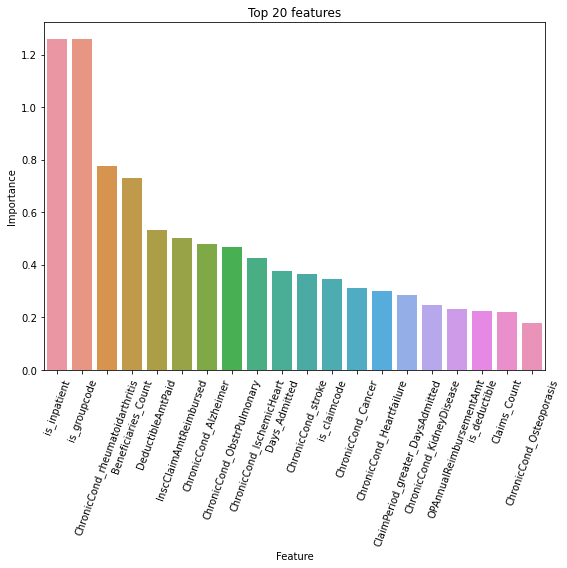

In [38]:
coef = best_log_model.coef_.tolist()[0]
cols = X_train.columns.tolist()
coef_cols = list(zip(cols, coef))

# Sorting each feature in descending order based on coefficient
top_features = pd.DataFrame(sorted(coef_cols, key=lambda x: abs(x[1]), reverse=True), columns=['Feature', 'Importance'])
plt.figure(figsize=(8,8))
sns.barplot(top_features.Feature[:20], abs(top_features.Importance[:20]))
plt.xticks(rotation=70)
plt.title("Top 20 features")
plt.tight_layout()

# 6. Visualizing test data with selected features

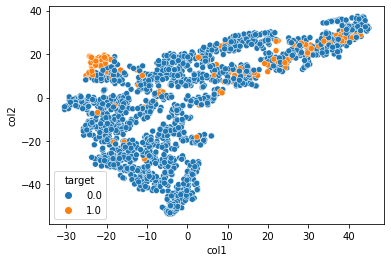

In [39]:
from sklearn.manifold import TSNE
test_data = X_test.values
X_embedded = TSNE(n_components=2, perplexity=50).fit_transform(test_data)

df1 = pd.DataFrame(np.hstack([X_embedded, y_test.reshape(-1, 1)]), columns=['col1','col2','target'])

sns.scatterplot(x='col1', y='col2', hue='target', data=df1)
plt.show()

## Observations:
<ul>
    <li> The selected features are able to segregate fraudulent(1) and non-fraudulent(0) providers quite fairly. </li>
    <li> There is a slight overlap in +ve and -ve points in some regions, which is hard to differentiate. This explains the mis-classsification of -ve points as +ve by Logistic Regression Model.</li>
    <li> A large section of +ve data points are segregated separately. </li>
</ul>

# 7. Saving best model

In [40]:
from joblib import dump, load
dump(best_log_model, 'D:/AI/Case_Studies/Personal_Case_Study_1/Saved_Models/best_logreg_model.joblib')
print("Model Saved successfully!")

Model Saved successfully!


# 8. Visualizing data with top 2 features

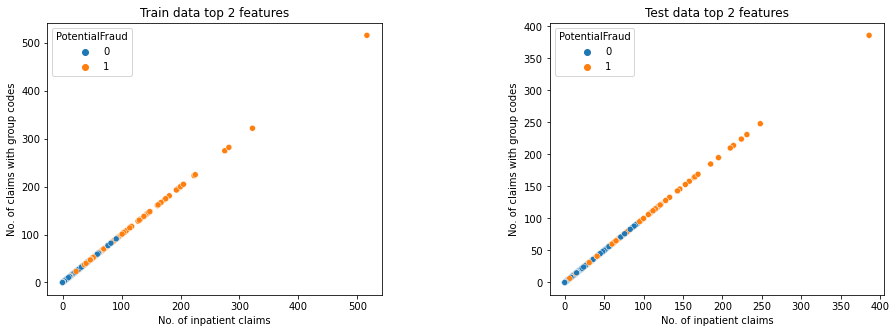

In [48]:
top2 = top_features.Feature[:2].values
train_data = X_train[top2].values
test_data = X_test[top2].values

df1 = pd.DataFrame(np.hstack([train_data, y_train.reshape(-1, 1)]), columns=['col1','col2','PotentialFraud'])
df2 = pd.DataFrame(np.hstack([test_data, y_test.reshape(-1, 1)]), columns=['col1','col2','PotentialFraud'])

f, axs = plt.subplots(1,2,figsize=(15,5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='col1', y='col2', hue='PotentialFraud', data=df1)
plt.xlabel('No. of inpatient claims')
plt.ylabel('No. of claims with group codes')
plt.title("Train data top 2 features")

plt.subplot(1, 2, 2)
sns.scatterplot(x='col1', y='col2', hue='PotentialFraud', data=df2)
plt.xlabel('No. of inpatient claims')
plt.ylabel('No. of claims with group codes')
plt.title("Test data top 2 features")
plt.subplots_adjust(wspace=0.5)
plt.show()

## Observations:
<ul> 
    <li> The data has been separated well into +ve and -ve class based on top 2 features. </li>
    <li> Majority of fraudulent providers have been separated well. There are few data points which overlap and are hard to separate. </li>
</ul>

# 9. Modelling with top 2 features

In [51]:
# Train data
x_tr = df1.drop(['PotentialFraud'], axis=1)
y_tr = df1.PotentialFraud

# Test data
x_te = df2.drop(['PotentialFraud'], axis=1)
y_te = df2.PotentialFraud

# Standardizing original data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Loading best model
from joblib import dump, load
clf = load('D:/AI/Case_Studies/Personal_Case_Study_1/Saved_Models/best_logreg_model.joblib')
print(clf)

LogisticRegression(C=0.23357214690901212, class_weight='balanced',
                   max_iter=1000)


In [52]:
# Train and test predictions
y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)
y_train_prob = clf.predict_proba(X_train_scaled)
y_test_prob = clf.predict_proba(X_test_scaled)

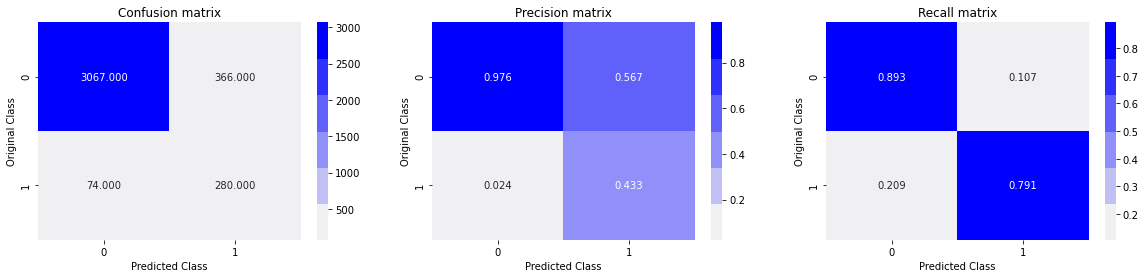

F1 score for train data:  0.5600000000000002
Recall for train data:  0.7909604519774012
Precision for train data:  0.43343653250773995


In [53]:
# Train Data Evaluation
plot_confusion_matrix(y_tr, y_train_pred)
print("F1 score for train data: ", f1_score(y_tr, y_train_pred))
print("Recall for train data: ", recall_score(y_tr, y_train_pred))
print("Precision for train data: ", precision_score(y_tr, y_train_pred))

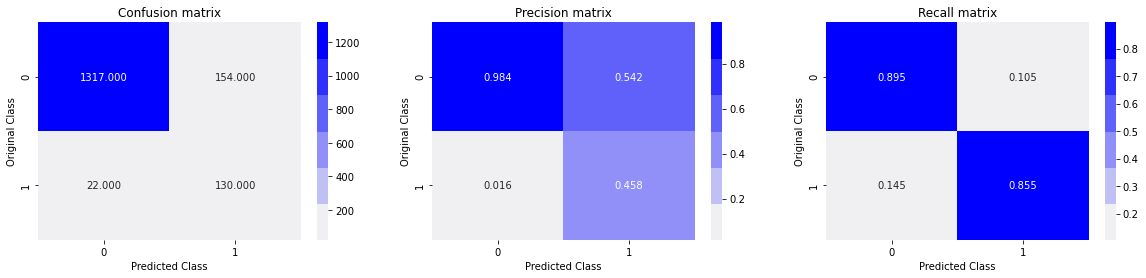

F1 score for train data:  0.5963302752293578
Recall for train data:  0.8552631578947368
Precision for train data:  0.45774647887323944


In [55]:
# Test Data Evaluation
plot_confusion_matrix(y_te, y_test_pred)
print("F1 score for train data: ", f1_score(y_te, y_test_pred))
print("Recall for train data: ", recall_score(y_te, y_test_pred))
print("Precision for train data: ", precision_score(y_te, y_test_pred))

# 10. Model Comparisons

In [57]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= ("Model Name", "Train Recall", "Test Recall"," Train F1", "Test F1", "Train AUC", "Test AUC")
tb.add_row(["Logistic Regression", 0.790, 0.855, 0.560, 0.596, 0.933, 0.944])
tb.add_row(["SVM", 1.000, 0.414, 0.999, 0.425, 1.0, 0.872])
tb.add_row(["Decision Tree", 1.000, 0.414, 0.999, 0.425, 1.000, 0.872])
tb.add_row(["Light GBM", 1.000, 0.638, 1.000, 0.636, 1.000, 0.939])
tb.add_row(["Random Forest", 1.0, 0.611, 1.000, 0.613, 1.000, 0.940])
tb.add_row(["Logistic Regression(top 2 features)", 0.790, 0.855, 0.560, 0.596, 0.933, 0.944])
print(tb)

+-------------------------------------+--------------+-------------+-----------+---------+-----------+----------+
|              Model Name             | Train Recall | Test Recall |  Train F1 | Test F1 | Train AUC | Test AUC |
+-------------------------------------+--------------+-------------+-----------+---------+-----------+----------+
|         Logistic Regression         |     0.79     |    0.855    |    0.56   |  0.596  |   0.933   |  0.944   |
|                 SVM                 |     1.0      |    0.414    |   0.999   |  0.425  |    1.0    |  0.872   |
|            Decision Tree            |     1.0      |    0.414    |   0.999   |  0.425  |    1.0    |  0.872   |
|              Light GBM              |     1.0      |    0.638    |    1.0    |  0.636  |    1.0    |  0.939   |
|            Random Forest            |     1.0      |    0.611    |    1.0    |  0.613  |    1.0    |   0.94   |
| Logistic Regression(top 2 features) |     0.79     |    0.855    |    0.56   |  0.596 

# 11. Conclusion

<ul>
    <li> The best results were obtained with Logistic Regression model.</li>
    <li> Logistic Regression was the only model which didn't overfit on the data and also met the business requirements of less false negatives(high recall score), decent F1 score and a high AUC score. </li>
    <li> The most important feature to predict if a provider is fraudulent is the no. of inpatient claims made by him/her. </li>
    <li> The no. of claims filed by a provider with serious chronic illnesses and the avg no. of days a patient was admitted are also some of the important variables to predict if a provider is fraudulent or not.
</ul>